[  27.42996982 1688.00393893    9.70623831] 23.157792317566113


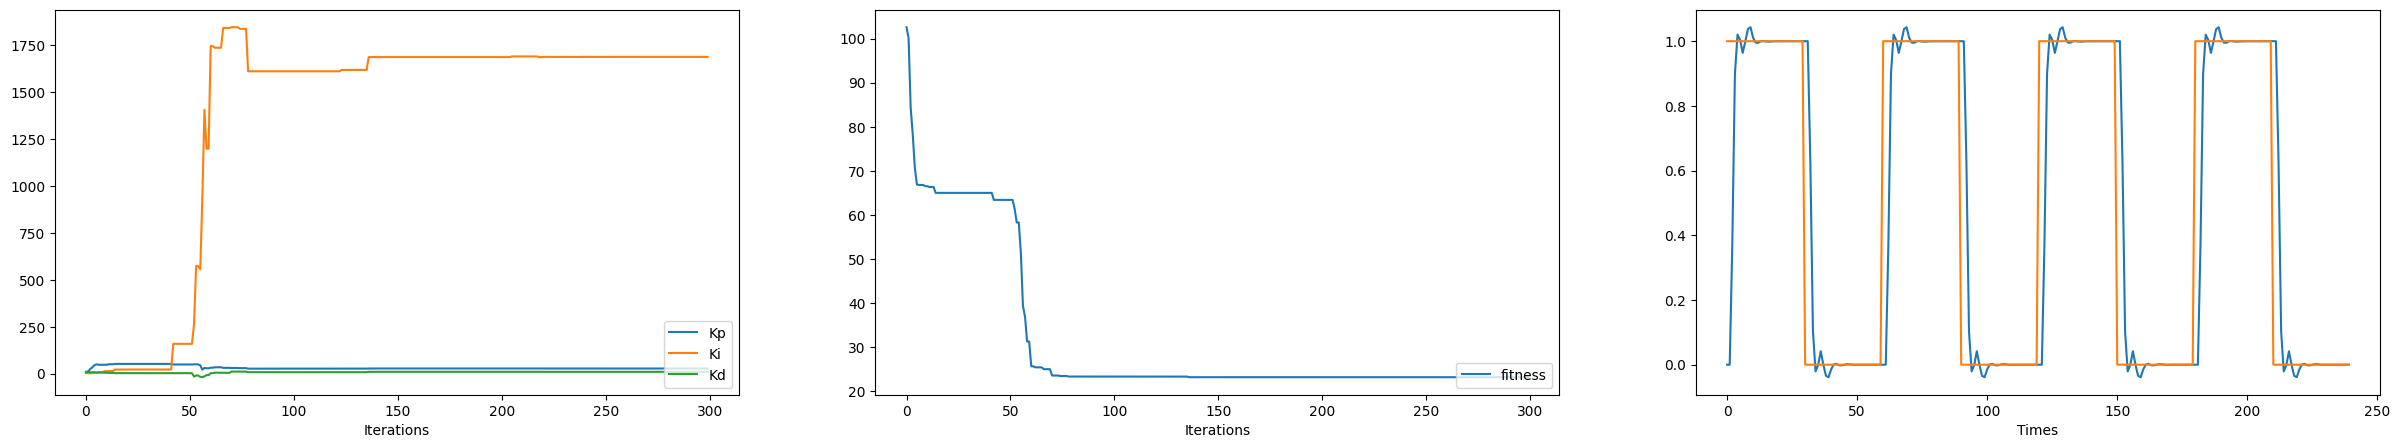

In [1]:
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

from prometheus_client import Counter
# import scipy.signal as signal


num_particles = 50
num_iterations = 300
pop_size = 10
num_dims = 3
weight = 2

c1 = 1.0
c2 = 1.0
c3 = 0.0
gbestx = []
gbesty = +np.inf
lbestx = []
# gbesty_period_temp = []
gbesty_period = [0]*60



total_error = [0]*num_particles
prev_error = [0]*num_particles

ling = 0.5
DT = 0.01
TARGET = [0]*240
state=[0,0,0]   #y(k+1),y(k),y(k-1)
u=[0,0,0]   #u(k+1),u(k),u(k-1)

Kp_plots = []
Ki_plots = []
Kd_plots = []
y_plots = []

#error=1
for i in range(8):
    if (i%2) == 0:
        num = 1
    else:
        num = 0
    for j in range(30):
        TARGET[30*i+j] = num



class Particle():
    def __init__(self,objective):
        global num_dims
        self.x = np.random.random([num_dims])*10
        self.y = np.inf
        self.v = np.random.uniform(-1,1,[num_dims])
        self.pbesty = self.y
        self.pbestx = copy.deepcopy(self.x)

    def update_velocity(self,weight,gbestx,lbestx=np.zeros(num_dims)):
        global c1,c2,c3,bounds,num_dims
        rand1 = np.random.random(num_dims)
        rand2 = np.random.random(num_dims)
        rand3 = np.random.random(num_dims)
        new_velocity = np.zeros(num_dims)
        for i in range(num_dims):
            new_velocity[i] = weight*random.random()*self.v[i] + c1*rand1[i]*(self.pbestx[i] - self.x[i]) + c2*rand2[i]*(gbestx[i] - self.x[i])+c3*rand3[i]*(lbestx[i]-self.x[i])
            self.v[i] = new_velocity[i]	               #Update velocity
            self.x[i] +=self.v[i]                      #Update position
            #self.x[i] = np.clip(self.x[i],*bounds[i])  #Clip state variables to bounds


def PSO(objective):
    global gbestx,gbesty,num_iterations,num_particles,num_dims,pop_size,weight
    particles=[]
    count=1

    # 初始化
    for i in range(num_particles):
        p = Particle(objective)
        particles.append(p)
        if p.y < gbesty:
            gbesty = p.y
            gbestx = copy.deepcopy(p.x)

    # 迭代
    for i in range(num_iterations):
        output = []
        for p in range(num_particles):
            count = count%pop_size
            particles[p].y = objective(particles[p].x,p)
            output.append(particles[p].y)
            if output[p] < particles[p].pbesty:
                particles[p].pbesty = output[p]
                particles[p].pbestx = copy.deepcopy(particles[p].x)
            if output[p] < gbesty or len(gbestx) == 0:              #Update Global best
                gbesty = output[p]
                gbestx = copy.deepcopy(particles[p].x)

            if count == 0:
                lbest = max(particles[p-pop_size+1:p+1], key = lambda p:p.y)
                lbestx = lbest.x
                for j in range(p-pop_size+1,p+1):
                    particles[j].update_velocity(weight,gbestx = gbestx,lbestx = lbestx)
                lbest = []
                lbestx=[]
            count+=1
        Kp_plots.append(gbestx[0])
        Ki_plots.append(gbestx[1])
        Kd_plots.append(gbestx[2])
        y_plots.append(gbesty)

    return gbestx

#output(y(k))
def fitfunction(u):
    return 2.6*state[1]-1.2*state[2]+u[1]+1.2*u[2]+ling*state[1]*math.sin(u[1]+u[2]+state[1]+state[2])

#算fitness
def ObjectiveFunction(X,p):
    global total_error,prev_error,gbesty_period,gbesty,state,u
    gbesty_period_temp =[]
    Kp=X[0]
    Ki=X[1]
    Kd=X[2]

    cost = 0
    state=[0,0,0]
    u=[0,0,0]

    for i in range(240):
        gbesty_period_temp.append(state[1])
        error = TARGET[i]-state[1]
        cost += abs(error)

        P = Kp * error
        I = Ki * total_error[p]
        D = Kd * (error-prev_error[p])
        u[0] = P + I + D
        if u[0]>=50:
            u[0]=50
        elif u[0]<=-50:
            u[0]=-50

        prev_error[p] = error
        total_error[p] = total_error[p] + error*DT

        state[0] = fitfunction(u)*DT
        u[2]=u[1]
        u[1]=u[0]
        state[2] = state[1]
        state[1] = state[0]

    if cost < gbesty:
        gbesty_period = gbesty_period_temp
    return cost

PSO(ObjectiveFunction)

fig = plt.figure(figsize=(30,5))

plt.subplot(1, 3, 1)
x = np.arange(0,len(Kp_plots),1)
plt.plot(x,Kp_plots,label = "Kp")
plt.plot(x,Ki_plots,label = "Ki")
plt.plot(x,Kd_plots,label = "Kd")
plt.legend(loc='lower right')
plt.xlabel("Iterations")

plt.subplot(1, 3, 2)
plt.plot(x,y_plots,label = "fitness")
plt.legend(loc='lower right')
plt.xlabel("Iterations")

print(gbestx,gbesty) #最佳解PID參數,最佳解的fitness(total_error)
plt.subplot(1, 3, 3)
x = np.arange(0,240,1)
y = gbesty_period
plt.plot(x,y,label = "wave")
plt.plot(x,TARGET,label = "TARGET")
plt.xlabel("Times")
plt.show()

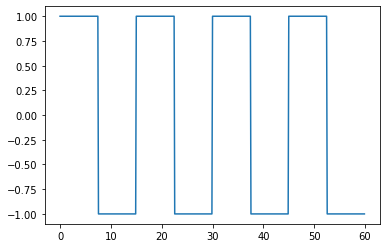

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

t = np.linspace(0, 60, 500, endpoint=False)
plt.plot(t, signal.square(2 * np.pi * 1/15 * t))

# PID

In [ ]:
import time
class PID:
    """
    PID算法实现
    """
    def __init__(self, P=0.2, I=0.0, D=0.0, current_time=None):
        """
        :param P: P算法超参数
        :param I: I算法超参数
        :param D: D算法超参数
        :param current_time: 当前时刻
        """
        self.Kp = P
        self.Ki = I
        self.Kd = D
        # 采样时间段
        self.sample_time = 0.00
        self.current_time = current_time if current_time is not None else time.time()
        self.last_time = self.current_time
        self.clear()
    def clear(self):
        """
        清理系数
        """
        self.SetPoint = 0.0
        self.PTerm = 0.0
        self.ITerm = 0.0
        self.DTerm = 0.0
        self.last_error = 0.0
        self.int_error = 0.0
        # 最大的波动值
        self.I_max_modify = 20.0
        self.output = 0.0
    def update(self, feedback_value, current_time=None):
        """
        math::
             u(k) = K_pe_k + K_i\sum_{j=0}^ke(j)\Delta t + K_d\frac{e(k) - e(k-1)}{\Delta t}
        """
        # 误差
        error = self.SetPoint - feedback_value
        self.current_time = current_time if current_time is not None else time.time()
        # 间隔时间
        delta_time = self.current_time - self.last_time
        if(delta_time >= self.sample_time):
            self.ITerm += error * delta_time
            # 限制积分项ITerm最大与最小值
            if(self.ITerm < -self.I_max_modify):
                self.ITerm = -self.I_max_modify
            elif(self.ITerm > self.I_max_modify):
                self.ITerm = self.I_max_modify
            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = (error - self.last_error) / delta_time
            # 更新时间
            self.last_time = self.current_time
            self.last_error = error
            # PID结果
            self.output = (self.Kp * error) + (self.Ki * self.ITerm) + (self.Kd * self.DTerm)

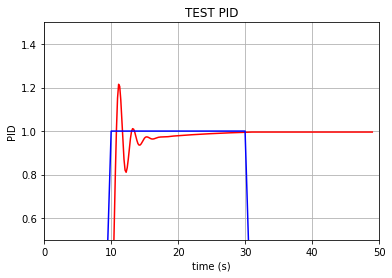

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, make_interp_spline
def test_pid():
    # PID中的超参数
    P = 1.2
    I = 1
    D = 0.001
    # 循环次数
    L = 50
    pid = PID(P, I, D)
    pid.SetPoint = 0.0
    pid.sample_time = 0.01
    feedback = 0
    feedback_list = []
    time_list = []
    setpoint_list = []
    for i in range(1, L):
        pid.update(feedback)
        output = pid.output
        if pid.SetPoint > 0:
            # 更新feedback
            feedback += (output - (1/i))

        # 目前只是为了观察
        if i > 9:
            pid.SetPoint = 1
        if i > 30:
            pid.SetPoint = 0
        time.sleep(0.02)
        # 为了绘制曲线，记录相应的数值
        feedback_list.append(feedback)
        setpoint_list.append(pid.SetPoint)
        time_list.append(i)
    time_sm = np.array(time_list)
    # 在指定的间隔内返回均匀间隔的数字
    time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300)
    # 拟合一条曲线 - 拟合后，曲线才能绘制出来
    feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)
    plt.plot(time_smooth, feedback_smooth, color='r')
    # 拟合目标变化句
    plt.plot(time_list, setpoint_list, color='b')
    plt.xlim((0, L))
    plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
    plt.xlabel('time (s)')
    plt.ylabel('PID')
    plt.title('TEST PID')
    plt.ylim((1-0.5, 1+0.5))
    plt.grid(True)
    plt.show()
if __name__ == "__main__":
    test_pid()